# IEEE Fraud Detection Kaggle Competition

features from: https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda/notebook#Feature-Engineering

- Add country match feature

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [56]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
num_folds = 5
SEED = 5000

In [57]:
import random, os
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [58]:
sampled_train = pd.read_csv('../../output/sampled_train_by_week.csv')
train = pd.read_csv('../../output/merged_train.csv')
test = pd.read_csv('../../output/merged_test.csv')

In [59]:
params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 

params['learning_rate'] = 0.005
params['n_estimators'] = 3000
params['early_stopping_rounds'] = 100    

In [60]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.981,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,Na

In [61]:
n_days_in_week_21 = 18509

In [62]:
"""
This module provides a class to split time-series data for back-testing and evaluation.
The aim was to extend the current sklearn implementation and extend it's uses.

Might be useful for some ;)
"""

import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)


class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

# Feature Engineering

In [63]:
valid_card = train['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

sampled_train['card1'] = np.where(sampled_train['card1'].isin(valid_card), sampled_train['card1'], np.nan)
train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [64]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8','D9',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    
    sampled_train[col+'_fq_enc'] = sampled_train[col].map(fq_encode)
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc'] = test[col].map(fq_encode)

In [65]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()
    
    sampled_train[col+'_target_mean'] = sampled_train[col].map(temp_dict)
    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean'] = test[col].map(temp_dict)

In [66]:
def country_match(df):
    
    temp_df = df[['card3', 'addr2']]
    temp_df['country_match'] = np.nan
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] != 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] == 60),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] != 60),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 185) & (temp_df['addr2'] == 60),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] == 96),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] != 96),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 144) & (temp_df['addr2'] == 96),
                                        0,
                                        temp_df['country_match'])

    
    return temp_df['country_match']

In [67]:
sampled_train['country_match'] = country_match(sampled_train)
train['country_match'] = country_match(train)
test['country_match'] = country_match(test)

sampled_train['country_match'] = sampled_train['country_match'].astype(object)
train['country_match'] = train['country_match'].astype(object)
test['country_match'] = test['country_match'].astype(object)

sampled_train['country_match'] = sampled_train['country_match'].fillna('unseen_before_label')
train['country_match'] = train['country_match'].fillna('unseen_before_label')
test['country_match'] = test['country_match'].fillna('unseen_before_label')

sampled_train['country_match'] = sampled_train['country_match'].astype(str)
train['country_match'] = train['country_match'].astype(str)
test['country_match'] = test['country_match'].astype(str)

le = LabelEncoder()
le.fit(list(train['country_match']) + list(test['country_match']))

sampled_train['country_match'] = le.transform(sampled_train['country_match'])
train['country_match'] = le.transform(train['country_match'])
test['country_match'] = le.transform(test['country_match'])

sampled_train['country_match'] = sampled_train['country_match'].astype('category')
train['country_match'] = train['country_match'].astype('category')
test['country_match'] = test['country_match'].astype('category')

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [68]:
for col in list(train):
    if train[col].dtype == 'O':
        print(col)
        sampled_train[col] = sampled_train[col].fillna('unseen_before_label')
        train[col] = train[col].fillna('unseen_before_label')
        test[col] = test[col].fillna('unseen_before_label')
        
        sampled_train[col] = sampled_train[col].astype(str)
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)

        le = LabelEncoder()
        le.fit(list(train[col]) + list(test[col]))
        sampled_train[col] = le.transform(sampled_train[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [69]:
valid_card = train['TransactionAmt'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

i_cols = ['card1','card2','card3','card5']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        sampled_train[new_col_name] = sampled_train[col].map(temp_df)
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)

In [70]:
sampled_train['bank_type'] = sampled_train['card3'].astype(str)+'_'+sampled_train['card5'].astype(str)
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

sampled_train['address_match'] = sampled_train['bank_type'].astype(str)+'_'+sampled_train['addr2'].astype(str)
train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()   
    sampled_train[col] = sampled_train[col].map(fq_encode)
    train[col] = train[col].map(fq_encode)
    test[col] = test[col].map(fq_encode)
    
sampled_train['address_match'] = sampled_train['address_match']/sampled_train['bank_type'] 
train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match'] = test['address_match']/test['bank_type'] 

In [71]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C3_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,ProductCD_target_mean,M4_target_mean,country_match,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,bank_type,address_match
0,2996780,0,302413,25.981,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,NaN,16,16,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Splitting into train, val, and test

In [72]:
sampled_train['isFraud'] = sampled_train['isFraud'].astype('category')

In [73]:
X = sampled_train

In [74]:
X.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C3_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,ProductCD_target_mean,M4_target_mean,country_match,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,bank_type,address_match
0,2996780,0,302413,25.981,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,NaN,16,16,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [75]:
# Split train into features and target
X = X.drop(['isFraud', 'TransactionID', 'TransactionDT', 'TransactionWeek',
            'bank_type', 'M1','addr2', 'P_emaildomain', 'R_emaildomain'] , axis=1)
y = sampled_train['isFraud']

In [76]:
tscv = TimeSeriesSplit(n_splits=num_folds,
                       test_size=n_days_in_week_21,
                       delay=n_days_in_week_21)

In [77]:
tscv

TimeSeriesSplit(delay=18509, force_step_size=None, n_splits=5,
        test_size=18509, train_size=None)

# Train LightGBM

In [78]:
# Create arrays for oof predictions and sub predictions
val_auc_scores = []
feature_importance_df = pd.DataFrame(columns = ['feature', 'importance'])

In [79]:
n_fold = 1

for train_index, val_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], verbose_eval=50)
    
    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)    
    val_auc = roc_auc_score(y_val.values, val_preds)
    print('AUROC on validation fold {}: {}'.format(n_fold, val_auc))
    val_auc_scores.append(val_auc)

    n_fold += 1

TRAIN: [     0      1      2 ... 117224 117225 117226] TEST: [135736 135737 135738 ... 154242 154243 154244]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.937235	valid_1's auc: 0.888448
[100]	training's auc: 0.949011	valid_1's auc: 0.893254
[150]	training's auc: 0.962774	valid_1's auc: 0.898853
[200]	training's auc: 0.972891	valid_1's auc: 0.900729
[250]	training's auc: 0.981294	valid_1's auc: 0.907025
[300]	training's auc: 0.986787	valid_1's auc: 0.911604
[350]	training's auc: 0.991037	valid_1's auc: 0.914586
[400]	training's auc: 0.994794	valid_1's auc: 0.916824
[450]	training's auc: 0.996924	valid_1's auc: 0.918238
[500]	training's auc: 0.998201	valid_1's auc: 0.919345
[550]	training's auc: 0.998999	valid_1's auc: 0.92003
[600]	training's auc: 0.999407	valid_1's auc: 0.920677
[650]	training's auc: 0.999636	valid_1's auc: 0.92143
[700]	training's auc: 0.999768	valid_1's auc: 0.921901
[750]	training's auc: 0.999848	valid_1's auc: 0.922441
[800]	training's auc: 0.9999	valid_1's auc: 0.922767
[850]	training's auc: 0.999936	valid_1's auc: 0.922982
[900]	t

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.919982	valid_1's auc: 0.876533
[100]	training's auc: 0.932085	valid_1's auc: 0.882
[150]	training's auc: 0.94433	valid_1's auc: 0.887632
[200]	training's auc: 0.955616	valid_1's auc: 0.893652
[250]	training's auc: 0.964067	valid_1's auc: 0.900298
[300]	training's auc: 0.97141	valid_1's auc: 0.905257
[350]	training's auc: 0.976683	valid_1's auc: 0.908272
[400]	training's auc: 0.981597	valid_1's auc: 0.911913
[450]	training's auc: 0.985952	valid_1's auc: 0.914263
[500]	training's auc: 0.989435	valid_1's auc: 0.916611
[550]	training's auc: 0.991909	valid_1's auc: 0.917951
[600]	training's auc: 0.994108	valid_1's auc: 0.918916
[650]	training's auc: 0.995818	valid_1's auc: 0.919681
[700]	training's auc: 0.99686	valid_1's auc: 0.920575
[750]	training's auc: 0.997656	valid_1's auc: 0.921101
[800]	training's auc: 0.998242	valid_1's auc: 0.92145
[850]	training's auc: 0.998655	valid_1's auc: 0.921541
[900]	trai

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.91039	valid_1's auc: 0.88261
[100]	training's auc: 0.922624	valid_1's auc: 0.88586
[150]	training's auc: 0.935612	valid_1's auc: 0.890804
[200]	training's auc: 0.945955	valid_1's auc: 0.895553
[250]	training's auc: 0.954406	valid_1's auc: 0.898772
[300]	training's auc: 0.96151	valid_1's auc: 0.901545
[350]	training's auc: 0.968918	valid_1's auc: 0.905099
[400]	training's auc: 0.974129	valid_1's auc: 0.907381
[450]	training's auc: 0.978548	valid_1's auc: 0.910518
[500]	training's auc: 0.982452	valid_1's auc: 0.913758
[550]	training's auc: 0.985552	valid_1's auc: 0.916168
[600]	training's auc: 0.987905	valid_1's auc: 0.918204
[650]	training's auc: 0.990036	valid_1's auc: 0.919629
[700]	training's auc: 0.991773	valid_1's auc: 0.921084
[750]	training's auc: 0.993241	valid_1's auc: 0.922364
[800]	training's auc: 0.994439	valid_1's auc: 0.923719
[850]	training's auc: 0.995359	valid_1's auc: 0.924655
[900]	t

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.907338	valid_1's auc: 0.857354
[100]	training's auc: 0.91927	valid_1's auc: 0.868294
[150]	training's auc: 0.932669	valid_1's auc: 0.875312
[200]	training's auc: 0.942207	valid_1's auc: 0.882892
[250]	training's auc: 0.949783	valid_1's auc: 0.888527
[300]	training's auc: 0.956453	valid_1's auc: 0.894995
[350]	training's auc: 0.962213	valid_1's auc: 0.900433
[400]	training's auc: 0.967395	valid_1's auc: 0.904754
[450]	training's auc: 0.972157	valid_1's auc: 0.909046
[500]	training's auc: 0.976213	valid_1's auc: 0.91308
[550]	training's auc: 0.979615	valid_1's auc: 0.91657
[600]	training's auc: 0.982368	valid_1's auc: 0.919375
[650]	training's auc: 0.984758	valid_1's auc: 0.922025
[700]	training's auc: 0.986933	valid_1's auc: 0.924102
[750]	training's auc: 0.988765	valid_1's auc: 0.925937
[800]	training's auc: 0.990311	valid_1's auc: 0.927644
[850]	training's auc: 0.991648	valid_1's auc: 0.929256
[900]	

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.902041	valid_1's auc: 0.869028
[100]	training's auc: 0.915596	valid_1's auc: 0.877745
[150]	training's auc: 0.925678	valid_1's auc: 0.886839
[200]	training's auc: 0.935568	valid_1's auc: 0.893414
[250]	training's auc: 0.945335	valid_1's auc: 0.899531
[300]	training's auc: 0.951495	valid_1's auc: 0.904286
[350]	training's auc: 0.957927	valid_1's auc: 0.908843
[400]	training's auc: 0.963757	valid_1's auc: 0.912803
[450]	training's auc: 0.968287	valid_1's auc: 0.916652
[500]	training's auc: 0.972161	valid_1's auc: 0.92077
[550]	training's auc: 0.975532	valid_1's auc: 0.924575
[600]	training's auc: 0.978547	valid_1's auc: 0.927391
[650]	training's auc: 0.981049	valid_1's auc: 0.929312
[700]	training's auc: 0.983372	valid_1's auc: 0.931493
[750]	training's auc: 0.985456	valid_1's auc: 0.932844
[800]	training's auc: 0.987135	valid_1's auc: 0.934466
[850]	training's auc: 0.988652	valid_1's auc: 0.935971
[900

In [80]:
print('Mean AUC {}'.format(np.mean(val_auc_scores)))

Mean AUC 0.9327499109975743


In [81]:
val_auc_scores

[0.9240889656803392,
 0.9223328087008379,
 0.9290338940299713,
 0.9379615874363327,
 0.9503322991403909]

# Feature importances

In [82]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df["feature"] = X.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.importance = feature_importance_df.importance.astype('int')

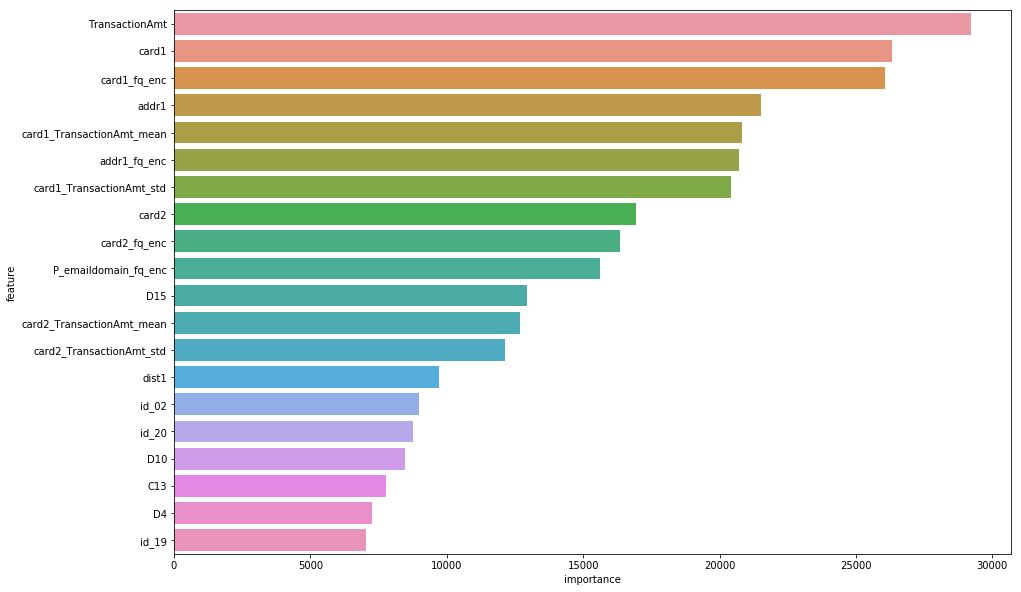

In [83]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [84]:
feature_importance_df

,feature,importance
0,TransactionAmt,29219
1,card1,26331
2,card1_fq_enc,26074
3,addr1,21521
4,card1_TransactionAmt_mean,20818
5,addr1_fq_enc,20728
6,card1_TransactionAmt_std,20423
7,card2,16926
8,card2_fq_enc,16338
9,P_emaildomain_fq_enc,15621


In [85]:
feature_importance_df[feature_importance_df['feature'] == 'country_match']

,feature,importance
145,country_match,688
